In [51]:
import os
import sys
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import hist
import mplhep as hep

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval # hyperparameter optimization
import pickle

parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    #args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook     
    args = parser.parse_args("--PhiRing --l1MatchGen".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen

printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
JEC_SF_LowerBound        = 1.00  # mainly for HF SFs
JEC_SF_UpperBound        = 2.00  # mainly for low pT jet SFs
snVtx                    = 'nVertexReco'

sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 
sL1JetEt_Definition1 = 'L1JetEt_PUS_PhiRing_CMSSW'

sIpFileNameNonZS  = "../data/L1T_Jet_MLInputs_2024_QCD_Pt15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter24Digi-FlatPU0to80_133X_mcRun3_2024_realistic_v8-v3_JEC2024v0_13_3_0_20240209.csv"
sIpFileNameZS     = "../data/L1T_Jet_MLInputs_2024_QCD_Pt15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter24Digi-FlatPU0to80_133X_mcRun3_2024_realistic_v8-v3_JEC2024v0_13_3_0_ZSHF3p5GeV_20240219.csv"

print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

sRefJetEt: GenJetEt, 	 sL1Jet: L1JetEt_PUS_PhiRing, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut False, l1Jet_PhiRing True, l1MatchOffline False, l1MatchGen True


In [52]:
dataNonZS_all = pd.read_csv(sIpFileNameNonZS)
dataZS_all = pd.read_csv(sIpFileNameZS)

In [53]:
if l1Jet_ChunkyDonut:
    dataNonZS_all[sL1JetEt] = dataNonZS_all['L1Jet9x9_RawEt'] - dataNonZS_all['L1Jet9x9_PUEt_ChunkyDonut']
    dataZS_all[sL1JetEt]    = dataZS_all['L1Jet9x9_RawEt']    - dataZS_all['L1Jet9x9_PUEt_ChunkyDonut']
else:
    dataNonZS_all[sL1JetEt] = dataNonZS_all['L1Jet9x9_RawEt'] - (dataNonZS_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
    dataZS_all[sL1JetEt]    = dataZS_all['L1Jet9x9_RawEt']    - (dataZS_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
    dataNonZS_all[sL1JetEt_Definition1] = dataNonZS_all['L1Jet9x9_RawEt'] - ((dataNonZS_all['L1Jet9x9_RawEt'] + dataNonZS_all['L1Jet9x9_EtSum7PUTowers'])/8.0)
    dataZS_all[sL1JetEt_Definition1]    = dataZS_all['L1Jet9x9_RawEt']    - ((dataZS_all['L1Jet9x9_RawEt']    + dataZS_all['L1Jet9x9_EtSum7PUTowers'])   /8.0)

In [54]:
print("Original sample: data_all.columns: {}, \ndata_all.shape: {}".format(dataZS_all.columns, dataZS_all.shape))

Original sample: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt', 'L1JetDefault_PUEt_PhiRing',
       'L1Jet9x9_RawEt', 'L1Jet9x9_EtSum7PUTowers',
       'L1Jet9x9_PUEt_ChunkyDonut', 'L1JetEt_PUS_PhiRing',
       'L1JetEt_PUS_PhiRing_CMSSW'],
      dtype='object'), 
data_all.shape: (2191492, 20)


In [55]:
dataNonZS_HF = dataNonZS_all[(dataNonZS_all.L1JetTowerIEtaAbs >= 31) & (dataNonZS_all.L1JetTowerIEtaAbs <= 41)]
dataZS_HF = dataZS_all[(dataZS_all.L1JetTowerIEtaAbs >= 31) & (dataZS_all.L1JetTowerIEtaAbs <= 41)]

In [56]:
dataZS_HF.head()

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Unpacked,nTT_Emulated,GenJetEt,nVertexGen,nMeanPUGen,matchedPFJetEtCorr,L1JetType,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_PhiRing,L1JetEt_PUS_PhiRing_CMSSW
10,1,1247,882177,25,0,323,28.007359,24,25,0.0,emu,29.000002,36,25.0,4.0,25.0,8.0,0.0,23.857143,20.875
15,1,1247,882182,14,0,290,45.454147,12,14,0.0,emu,48.500000,33,48.0,6.5,48.0,5.0,0.0,47.285714,41.375
17,1,1247,882184,13,0,169,99.796364,9,13,0.0,emu,104.000000,31,92.0,12.0,92.0,6.0,1.0,91.142857,79.750
32,1,1247,882183,36,0,506,29.245029,47,36,0.0,emu,30.000002,35,23.0,4.5,23.0,16.0,0.0,20.714286,18.125
35,1,1247,882176,70,0,913,31.516657,63,70,0.0,emu,21.500002,33,32.5,19.0,32.5,121.5,8.0,15.142857,13.250


In [57]:
dataNonZS_all.describe()

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Unpacked,nTT_Emulated,GenJetEt,nVertexGen,nMeanPUGen,matchedPFJetEtCorr,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_PhiRing,L1JetEt_PUS_PhiRing_CMSSW
count,2096569.0,2.096569e+06,2.096569e+06,2.096569e+06,2096569.0,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2096569.0,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06,2.096569e+06
mean,1.0,7.025921e+02,4.970816e+05,4.064983e+01,0.0,1.109423e+03,1.394306e+02,4.121640e+01,4.064983e+01,0.0,1.347440e+02,1.541763e+01,1.061397e+02,2.480007e+01,1.061397e+02,9.399186e+01,7.616444e+00,9.271233e+01,8.112328e+01
std,0.0,4.068549e+02,2.880530e+05,2.338547e+01,0.0,6.714815e+02,1.277788e+02,2.429704e+01,2.338547e+01,0.0,1.239093e+02,9.825185e+00,1.010705e+02,2.094648e+01,1.010705e+02,1.117717e+02,8.103552e+00,9.850507e+01,8.619193e+01
min,1.0,1.000000e+00,1.000000e+00,0.000000e+00,0.0,8.100000e+01,3.000010e+00,0.000000e+00,0.000000e+00,0.0,5.000010e-01,1.000000e+00,4.000000e+00,5.000000e-01,4.000000e+00,0.000000e+00,0.000000e+00,7.142857e-02,6.250000e-02
25%,1.0,3.530000e+02,2.497920e+05,2.100000e+01,0.0,4.840000e+02,4.817546e+01,2.100000e+01,2.100000e+01,0.0,4.400000e+01,7.000000e+00,3.450000e+01,1.000000e+01,3.450000e+01,3.100000e+01,3.000000e+00,2.307143e+01,2.018750e+01
50%,1.0,7.050000e+02,4.990780e+05,4.100000e+01,0.0,1.041000e+03,9.688988e+01,4.100000e+01,4.100000e+01,0.0,9.350000e+01,1.400000e+01,7.050000e+01,1.850000e+01,7.050000e+01,5.350000e+01,5.000000e+00,5.571429e+01,4.875000e+01
75%,1.0,1.055000e+03,7.464820e+05,6.100000e+01,0.0,1.671000e+03,1.925729e+02,6.100000e+01,6.100000e+01,0.0,1.860000e+02,2.400000e+01,1.450000e+02,3.300000e+01,1.450000e+02,1.070000e+02,9.000000e+00,1.302143e+02,1.139375e+02
max,1.0,1.413000e+03,1.000000e+06,8.000000e+01,0.0,3.210000e+03,2.156464e+03,1.160000e+02,8.000000e+01,0.0,1.022500e+03,4.100000e+01,9.400000e+02,3.540000e+02,9.400000e+02,2.464500e+03,3.145000e+02,8.154286e+02,7.135000e+02


In [58]:
dataZS_all.describe()

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Unpacked,nTT_Emulated,GenJetEt,nVertexGen,nMeanPUGen,matchedPFJetEtCorr,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_PhiRing,L1JetEt_PUS_PhiRing_CMSSW
count,2191492.0,2.191492e+06,2.191492e+06,2.191492e+06,2191492.0,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2191492.0,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06,2.191492e+06
mean,1.0,7.078648e+02,5.008146e+05,4.066035e+01,0.0,5.127273e+02,1.393469e+02,4.122637e+01,4.066035e+01,0.0,1.342200e+02,1.542433e+01,1.031774e+02,2.228060e+01,1.031774e+02,7.679512e+01,5.376826e+00,9.220671e+01,8.068087e+01
std,0.0,4.080131e+02,2.888731e+05,2.338574e+01,0.0,2.519927e+02,1.277812e+02,2.429673e+01,2.338574e+01,0.0,1.241888e+02,9.828772e+00,1.020336e+02,2.017067e+01,1.020336e+02,9.785928e+01,4.867954e+00,9.869829e+01,8.636101e+01
min,1.0,1.000000e+00,1.000000e+00,0.000000e+00,0.0,7.800000e+01,3.000010e+00,0.000000e+00,0.000000e+00,0.0,5.000010e-01,1.000000e+00,4.000000e+00,5.000000e-01,4.000000e+00,0.000000e+00,0.000000e+00,7.142857e-02,6.250000e-02
25%,1.0,3.540000e+02,2.504428e+05,2.100000e+01,0.0,3.000000e+02,4.812687e+01,2.100000e+01,2.100000e+01,0.0,4.300000e+01,7.000000e+00,3.050000e+01,9.000000e+00,3.050000e+01,2.750000e+01,2.000000e+00,2.207143e+01,1.931250e+01
50%,1.0,7.090000e+02,5.019060e+05,4.100000e+01,0.0,4.790000e+02,9.679755e+01,4.100000e+01,4.100000e+01,0.0,9.300000e+01,1.400000e+01,6.550000e+01,1.600000e+01,6.550000e+01,4.800000e+01,4.500000e+00,5.500000e+01,4.812500e+01
75%,1.0,1.062000e+03,7.514165e+05,6.100000e+01,0.0,6.840000e+02,1.924422e+02,6.100000e+01,6.100000e+01,0.0,1.860000e+02,2.400000e+01,1.430000e+02,2.850000e+01,1.430000e+02,8.400000e+01,7.500000e+00,1.298571e+02,1.136250e+02
max,1.0,1.413000e+03,1.000000e+06,8.000000e+01,0.0,2.120000e+03,2.156464e+03,1.160000e+02,8.000000e+01,0.0,1.022500e+03,4.100000e+01,9.400000e+02,3.540000e+02,9.400000e+02,2.464500e+03,3.145000e+02,8.154286e+02,7.135000e+02


In [59]:
dataNonZS_tmp = dataNonZS_all.copy()

In [60]:
dataNonZS_tmp['L1TJetEt_CMSSWDefinition'] = dataNonZS_tmp['L1JetDefault_RawEt'] - dataNonZS_tmp['L1JetDefault_PUEt_PhiRing']
dataNonZS_tmp['L1TJetEt_Definition2'] = dataNonZS_tmp['L1JetEt_PUS_PhiRing']

In [61]:
dataNonZS_tmp[abs(dataNonZS_tmp.L1JetDefault_RawEt-4)<0.001][['nVertexGen', 'GenJetEt', 'L1JetDefault_RawEt','L1JetDefault_PUEt_PhiRing', 'L1TJetEt_CMSSWDefinition', 'L1TJetEt_Definition2']]

,nVertexGen,GenJetEt,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1TJetEt_CMSSWDefinition,L1TJetEt_Definition2
30658,2,14.159356,4.0,1.5,2.5,2.714286
55517,10,3.071035,4.0,1.5,2.5,2.357143
61295,14,4.348049,4.0,3.0,1.0,1.071429
63316,2,5.705510,4.0,1.0,3.0,2.928571
67339,13,10.524670,4.0,0.5,3.5,3.500000
...,...,...,...,...,...,...
2000215,5,5.221332,4.0,1.0,3.0,3.285714
2014913,1,17.412752,4.0,0.5,3.5,3.642857
2048140,17,7.908966,4.0,2.5,1.5,1.500000
2050335,15,9.210566,4.0,2.5,1.5,1.285714


In [62]:
dataNonZS_tmp[(abs(dataNonZS_tmp.L1JetDefault_RawEt-4)<0.001) & (dataNonZS_tmp.L1TJetEt_CMSSWDefinition<1)]

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Unpacked,nTT_Emulated,GenJetEt,nVertexGen,nMeanPUGen,matchedPFJetEtCorr,...,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_PhiRing,L1JetEt_PUS_PhiRing_CMSSW,L1TJetEt_CMSSWDefinition,L1TJetEt_Definition2
104597,1,501,354014,34,0,847,5.216861,39,34,0.0,...,19,4.0,3.5,4.0,24.5,2.0,0.500000,0.4375,0.5,0.500000
505132,1,546,386508,39,0,711,5.696245,37,39,0.0,...,13,4.0,3.5,4.0,24.0,2.0,0.571429,0.5000,0.5,0.571429
995348,1,678,479611,9,0,562,3.949417,12,9,0.0,...,13,4.0,3.5,4.0,24.0,5.0,0.571429,0.5000,0.5,0.571429
1097099,1,868,614184,17,0,666,13.612057,25,17,0.0,...,20,4.0,3.5,4.0,24.5,3.5,0.500000,0.4375,0.5,0.500000
1610789,1,297,209879,18,0,241,11.050792,13,18,0.0,...,25,4.0,3.5,4.0,27.5,0.0,0.071429,0.0625,0.5,0.071429
1677226,1,954,675418,1,0,249,13.920378,1,1,0.0,...,26,4.0,3.5,4.0,24.0,0.0,0.571429,0.5000,0.5,0.571429
1981329,1,736,520483,8,0,206,6.569203,11,8,0.0,...,25,4.0,3.5,4.0,24.0,0.0,0.571429,0.5000,0.5,0.571429


In [63]:
dataNonZS_all[abs(dataNonZS_all.L1JetDefault_RawEt-4)<0.001]

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Unpacked,nTT_Emulated,GenJetEt,nVertexGen,nMeanPUGen,matchedPFJetEtCorr,L1JetType,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_PhiRing,L1JetEt_PUS_PhiRing_CMSSW
30658,1,60,42186,0,0,252,14.159356,2,0,0.0,emu,11.500001,26,4.0,1.5,4.0,9.0,2.5,2.714286,2.3750
55517,1,527,372714,14,0,319,3.071035,10,14,0.0,emu,13.000001,11,4.0,1.5,4.0,11.5,2.0,2.357143,2.0625
61295,1,573,405063,16,0,381,4.348049,14,16,0.0,emu,11.500001,18,4.0,3.0,4.0,20.5,3.0,1.071429,0.9375
63316,1,113,79622,4,0,257,5.705510,2,4,0.0,emu,12.000001,25,4.0,1.0,4.0,7.5,0.0,2.928571,2.5625
67339,1,589,416367,7,0,311,10.524670,13,7,0.0,emu,16.500002,18,4.0,0.5,4.0,3.5,0.5,3.500000,3.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000215,1,481,340119,5,0,218,5.221332,5,5,0.0,emu,12.000001,25,4.0,1.0,4.0,5.0,0.0,3.285714,2.8750
2014913,1,462,326947,0,0,211,17.412752,1,0,0.0,emu,18.000002,17,4.0,0.5,4.0,2.5,1.0,3.642857,3.1875
2048140,1,999,706605,12,0,333,7.908966,17,12,0.0,emu,11.000001,13,4.0,2.5,4.0,17.5,1.5,1.500000,1.3125
2050335,1,1,315,9,0,431,9.210566,15,9,0.0,emu,10.500001,23,4.0,2.5,4.0,19.0,0.5,1.285714,1.1250


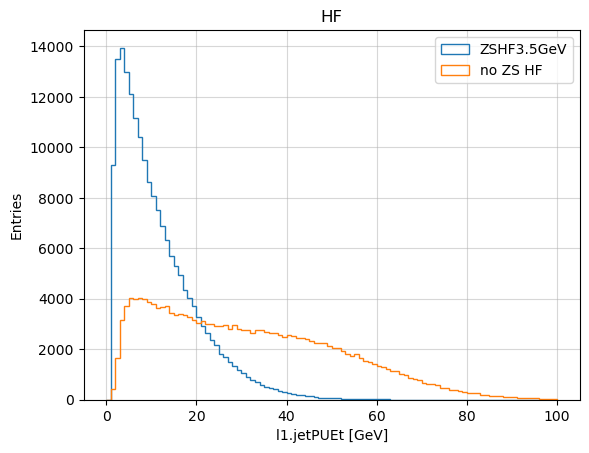

In [64]:
fig, axs = plt.subplots()

axs.hist(
    dataZS_HF.L1JetDefault_PUEt_PhiRing,
    bins=100, range=(0,100),
    label='ZSHF3.5GeV',
    histtype='step'
)
axs.hist(
    dataNonZS_HF.L1JetDefault_PUEt_PhiRing,
    bins=100, range=(0,100),
    label='no ZS HF',
    histtype='step'
)

axs.set_xlabel('l1.jetPUEt [GeV]')
axs.set_ylabel('Entries')
axs.set_title('HF' )
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)


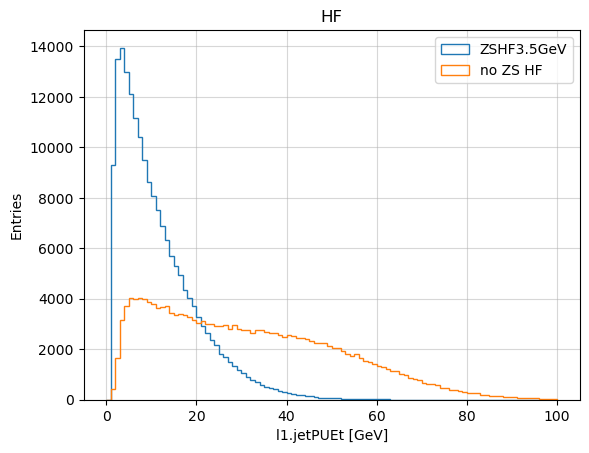

In [65]:
fig, axs = plt.subplots()

axs.hist(
    (dataZS_HF.L1Jet9x9_EtSum7PUTowers + dataZS_HF.L1Jet9x9_RawEt)/8.0,
    bins=100, range=(0,100),
    label='ZSHF3.5GeV',
    histtype='step'
)
axs.hist(
    (dataNonZS_HF.L1Jet9x9_EtSum7PUTowers + dataNonZS_HF.L1Jet9x9_RawEt)/8.0,
    bins=100, range=(0,100),
    label='no ZS HF',
    histtype='step'
)

axs.set_xlabel('l1.jetPUEt [GeV]')
axs.set_ylabel('Entries')
axs.set_title('HF' )
axs.legend()
#axs.set_ylim(0,5000)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

In [66]:
dataNonZS_HF.columns


Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Unpacked', 'nTT_Emulated', 'GenJetEt', 'nVertexGen', 'nMeanPUGen',
       'matchedPFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt', 'L1JetDefault_PUEt_PhiRing',
       'L1Jet9x9_RawEt', 'L1Jet9x9_EtSum7PUTowers',
       'L1Jet9x9_PUEt_ChunkyDonut', 'L1JetEt_PUS_PhiRing',
       'L1JetEt_PUS_PhiRing_CMSSW'],
      dtype='object')

In [67]:
dataNonZS_HF['L1JetDefault_RawEt'] - dataNonZS_HF['L1Jet9x9_RawEt']

0          0.0
13         0.0
36         0.0
72         0.0
78         0.0
          ... 
2096519    0.0
2096553    0.0
2096562    0.0
2096565    0.0
2096567    0.0
Length: 178884, dtype: float64

In [68]:
((dataNonZS_HF['L1Jet9x9_EtSum7PUTowers'] + dataNonZS_HF['L1Jet9x9_RawEt'])/8.0 - dataNonZS_HF['L1JetDefault_PUEt_PhiRing']).describe()

count    178884.000000
mean          0.189217
std           0.139737
min           0.000000
25%           0.125000
50%           0.250000
75%           0.375000
max           0.437500
dtype: float64

sL1JetEt = 'L1JetEt_PUS_PhiRing', GenJetEt


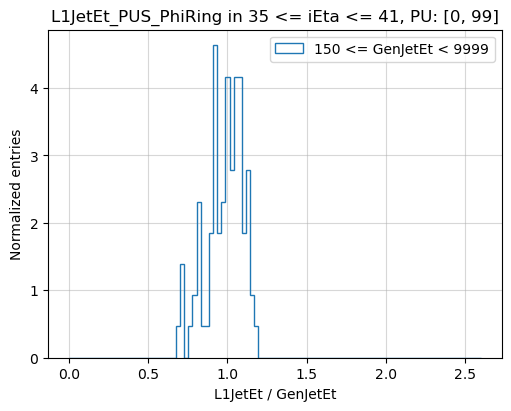

In [89]:
PU_Cat = OD()
PU_Cat['PUAll'] = [0, 99]
#PU_Cat['PU40To60'] = [30, 40] #[40, 60]

PT_CAT = OD()
#PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
#PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
#PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
#PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
#PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT
#PT_CAT['Pt50To80'] = [50,  75,  80]  ## Low pT, turn-on threshold, high pT 
PT_CAT['Pt150To250'] = [150,  75,  9999]  ## Low pT, turn-on threshold, high pT 

IETA_CAT2 = OD()
#IETA_CAT2['HF1']   = [30, 32]
#IETA_CAT2['HF2']   = [33, 36] 
#IETA_CAT2['HF3']   = [37, 41]
IETA_CAT2['HFFull']   = [35, 41]
#iEtaBin_first = 36 # 31
#iEtaBin_last  = 41

for iEtaCatname, iEtaCatRange in IETA_CAT2.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1] 

    for PU_category, PURange in PU_Cat.items():
        PURangeMin = PURange[0]
        PURangeMax = PURange[1]

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')

        for pt_cat, pt_range in PT_CAT.items(): 
            '''
            data_copy1_iEtaBin = dataNonZS_HF[ (
                (dataNonZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
                (dataNonZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
                (dataNonZS_HF[sRefJetEt] >= pt_range[0]) & 
                (dataNonZS_HF[sRefJetEt] <  pt_range[2]) & 
                (dataNonZS_HF[snVtx]     >= PURangeMin ) & 
                (dataNonZS_HF[snVtx]     <  PURangeMax ) )]
            '''
            data_copy1_iEtaBin = dataZS_HF[ (
                (dataZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
                (dataZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
                (dataZS_HF[sRefJetEt] >= pt_range[0]) & 
                (dataZS_HF[sRefJetEt] <  pt_range[2]) & 
                (dataZS_HF[snVtx]     >= PURangeMin ) & 
                (dataZS_HF[snVtx]     <  PURangeMax ) )]
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
                histtype='step',#, linewidth=2
                density=True
            )
            '''
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt_Definition1]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= %s < %d, %s' % (pt_range[0], sRefJetEt, pt_range[2], sL1JetEt_Definition1),
                histtype='step',#, linewidth=2
                density=True
            )
            axs.hist(
                ((data_copy1_iEtaBin['L1JetDefault_RawEt'] - data_copy1_iEtaBin['L1JetDefault_PUEt_PhiRing'])/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= %s < %d, %s' % (pt_range[0], sRefJetEt, pt_range[2], 'Definition default'),
                histtype='step',#, linewidth=2
                density=True
            )
            '''
        axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s in %d <= iEta <= %d, PU: [%d, %d]' % (sL1JetEt, iEtaBin_first, iEtaBin_last, PURangeMin,PURangeMax))
        axs.legend()

        axs.grid(which='minor', alpha=0.2)
        axs.grid(which='major', alpha=0.5)    

print(f"{sL1JetEt = }, {sRefJetEt}")

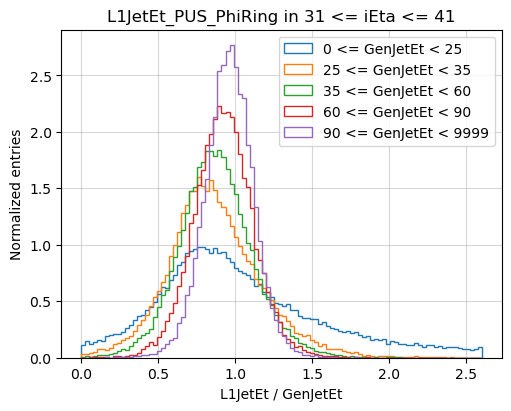

In [70]:
PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
iEtaBin_first = 31
iEtaBin_last  = 41

for pt_cat, pt_range in PT_CAT.items(): 
    data_copy1_iEtaBin = dataNonZS_HF[ (
        (dataNonZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (dataNonZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
        (dataNonZS_HF[sRefJetEt] >= pt_range[0]) & 
        (dataNonZS_HF[sRefJetEt] <  pt_range[2]) )]
    axs.hist(
        (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
        bins=100, range=(0, 2.6),
        label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
        histtype='step',#, linewidth=2
        density=True
    )
axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
axs.set_ylabel('Normalized entries')
axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

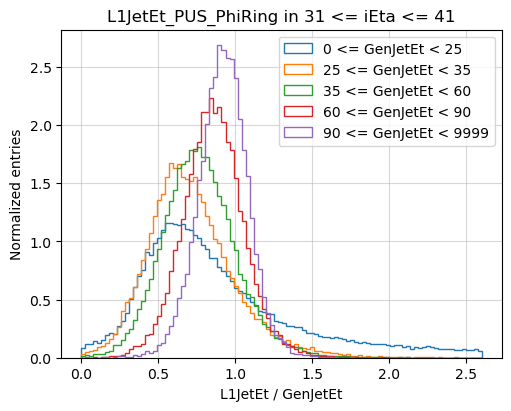

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
iEtaBin_first = 31
iEtaBin_last  = 41

for pt_cat, pt_range in PT_CAT.items(): 
    data_copy1_iEtaBin = dataZS_HF[ (
        (dataZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (dataZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
        (dataZS_HF[sRefJetEt] >= pt_range[0]) & 
        (dataZS_HF[sRefJetEt] <  pt_range[2]) )]
    axs.hist(
        (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
        bins=100, range=(0, 2.6),
        label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
        histtype='step',#, linewidth=2
        density=True
    )
axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
axs.set_ylabel('Normalized entries')
axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

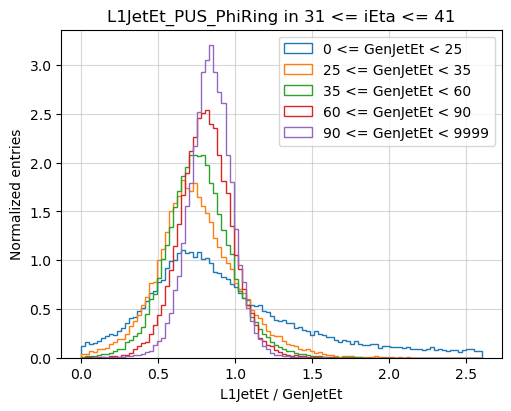

In [72]:
PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
iEtaBin_first = 31
iEtaBin_last  = 41

for pt_cat, pt_range in PT_CAT.items(): 
    data_copy1_iEtaBin = dataNonZS_HF[ (
        (dataNonZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (dataNonZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
        (dataNonZS_HF[sRefJetEt] >= pt_range[0]) & 
        (dataNonZS_HF[sRefJetEt] <  pt_range[2]) )]
    axs.hist(
        #(data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
        ((data_copy1_iEtaBin['L1Jet9x9_RawEt'] - ((data_copy1_iEtaBin['L1Jet9x9_EtSum7PUTowers'] + data_copy1_iEtaBin['L1Jet9x9_RawEt'])/8.0) )/data_copy1_iEtaBin[sRefJetEt]), 
        bins=100, range=(0, 2.6),
        label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
        histtype='step',#, linewidth=2
        density=True
    )
axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
axs.set_ylabel('Normalized entries')
axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

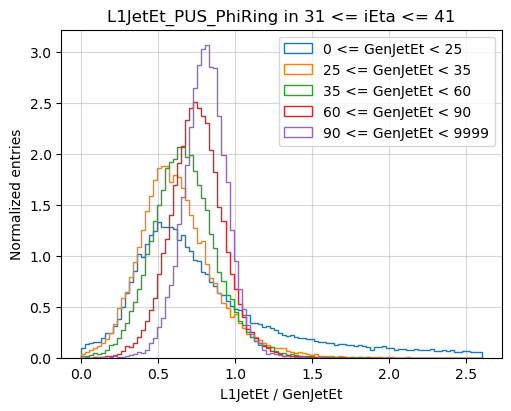

In [73]:
PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
iEtaBin_first = 31
iEtaBin_last  = 41

for pt_cat, pt_range in PT_CAT.items(): 
    data_copy1_iEtaBin = dataZS_HF[ (
        (dataZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (dataZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
        (dataZS_HF[sRefJetEt] >= pt_range[0]) & 
        (dataZS_HF[sRefJetEt] <  pt_range[2]) )]
    axs.hist(
        #(data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
        ((data_copy1_iEtaBin['L1Jet9x9_RawEt'] - ((data_copy1_iEtaBin['L1Jet9x9_EtSum7PUTowers'] + data_copy1_iEtaBin['L1Jet9x9_RawEt'])/8.0) )/data_copy1_iEtaBin[sRefJetEt]), 
        bins=100, range=(0, 2.6),
        label='%d <= %s < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
        histtype='step',#, linewidth=2
        density=True
    )
axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
axs.set_ylabel('Normalized entries')
axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

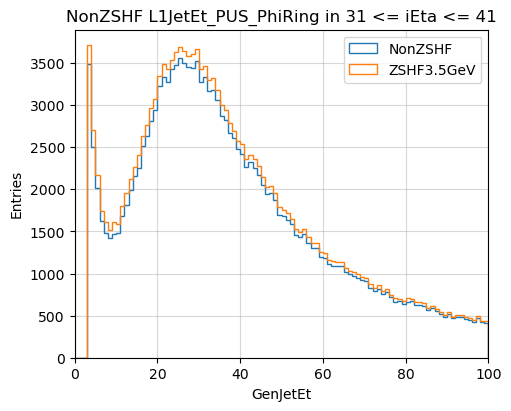

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
iEtaBin_first = 31
iEtaBin_last  = 41

data_copy1_iEtaBin = dataNonZS_HF[ (
    (dataNonZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
    (dataNonZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) )]
axs.hist(
    (data_copy1_iEtaBin[sRefJetEt]), 
    #((data_copy1_iEtaBin['L1Jet9x9_RawEt'] - ((data_copy1_iEtaBin['L1Jet9x9_EtSum7PUTowers'] + data_copy1_iEtaBin['L1Jet9x9_RawEt'])/8.0) )/data_copy1_iEtaBin[sRefJetEt]), 
    bins=100, range=(0, 100),
    label='NonZSHF',
    histtype='step',#, linewidth=2
    density=False
)

data_copy1_iEtaBin = dataZS_HF[ (
    (dataZS_HF[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
    (dataZS_HF[sL1JetTowerIEtaAbs] <= iEtaBin_last) )]
axs.hist(
    (data_copy1_iEtaBin[sRefJetEt]), 
    #((data_copy1_iEtaBin['L1Jet9x9_RawEt'] - ((data_copy1_iEtaBin['L1Jet9x9_EtSum7PUTowers'] + data_copy1_iEtaBin['L1Jet9x9_RawEt'])/8.0) )/data_copy1_iEtaBin[sRefJetEt]), 
    bins=100, range=(0, 100),
    label='ZSHF3.5GeV',
    histtype='step',#, linewidth=2
    density=False
)

axs.set_xlabel('%s' % (sRefJetEt))
axs.set_ylabel('Entries')
axs.set_title('NonZSHF %s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
axs.legend()
axs.set_xlim(0, 100)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)